In [1]:
"""
A simple example of the Stiefel landing algorithm on PCA problem
"""
from time import time

import matplotlib.pyplot as plt

import numpy as np
import torch
import geoopt
from geoopt.optim import RiemannianSGD

from landing_stiefel import LandingStiefelSGD
from plam import PLAMStiefelSGD


torch.manual_seed(0)

In [2]:
m = 20000        # Dimension of samples
n = 500         # Number of samples
p = 100          # Dimension of the subspace

batch_size = 10000

N_runs = 20

method_names = ["Landing", 'PLAM', "Retraction"]
methods =  [LandingStiefelSGD, PLAMStiefelSGD, RiemannianSGD]
ns_epochs = [1000, 1000, 1000]

learning_rate = 1e-3


device = 'cuda'

def generate_problem(m, n, p, sdev = 1):
    '''
    Generates A = L + N where L = U @ S @ V^T is a rank-r and 
    N is Gaussian noise
    
    '''
    U, _ = torch.linalg.qr(torch.randn(m,p), mode='reduced')
    V, _ = torch.linalg.qr(torch.randn(n,p), mode='reduced')
    S = torch.linspace(1, 0.5, steps=p)
    S = S / np.linalg.norm(S, 2)
    L = U @ S.diag() @ V.transpose(-1, -2)
    A = L + sdev * torch.randn(m,n)
    return A

In [3]:
time_list = {}
loss_list = {}
distance_list = {}

for method_name, method, n_epochs in zip(method_names, methods, ns_epochs):
    time_list[method_name] = []
    loss_list[method_name] = []
    distance_list[method_name] = []
    for run_i in range(N_runs):
        print('Starting the run '+str(run_i))
        
        A = generate_problem(m, n, p, sdev=0.)        
        A = A.to(device)

        # Compute the true solution
        _, _, vh = torch.linalg.svd(A, full_matrices=False)
        x_star = vh[:p,:].T
        loss_star = -.5 * (torch.matmul(A, x_star) ** 2).sum() / m
        loss_star = loss_star.item()

        # Project randn point on the manifold
        init_weights = torch.randn(n, p).to(device)
        param = geoopt.ManifoldParameter(
            init_weights.clone(), manifold=geoopt.Stiefel(canonical=False)
        )
        with torch.no_grad():
            param.proj_()


        optimizer = method((param,), lr=learning_rate)
        t0 = time()
        for epoch in range(n_epochs):
            optimizer.zero_grad()
            idx = epoch % (m // batch_size)
            a = A[idx * batch_size: (idx + 1) * batch_size]
            loss = -.5 * (torch.matmul(a, param) ** 2).sum() / batch_size
            loss.backward()
            optimizer.step()
        
        t_final = time() - t0
        time_list[method_name].append(t_final)
        loss_list[method_name].append(loss.item() - loss_star)
        #print(loss.item() - loss_star)
        distance = torch.norm(param.data.transpose(-1, -2).matmul(param.data) - 
                        torch.eye(p, device=param.data.device))
        #print(distance.item())
        distance_list[method_name].append(distance.item())

Starting the run 0
Starting the run 1
Starting the run 2
Starting the run 3
Starting the run 4
Starting the run 5
Starting the run 6
Starting the run 7
Starting the run 8
Starting the run 9
Starting the run 10
Starting the run 11
Starting the run 12
Starting the run 13
Starting the run 14
Starting the run 15
Starting the run 16
Starting the run 17
Starting the run 18
Starting the run 19
Starting the run 0
Starting the run 1
Starting the run 2
Starting the run 3
Starting the run 4
Starting the run 5
Starting the run 6
Starting the run 7
Starting the run 8
Starting the run 9
Starting the run 10
Starting the run 11
Starting the run 12
Starting the run 13
Starting the run 14
Starting the run 15
Starting the run 16
Starting the run 17
Starting the run 18
Starting the run 19
Starting the run 0
Starting the run 1
Starting the run 2
Starting the run 3
Starting the run 4
Starting the run 5
Starting the run 6
Starting the run 7
Starting the run 8
Starting the run 9
Starting the run 10
Starting t

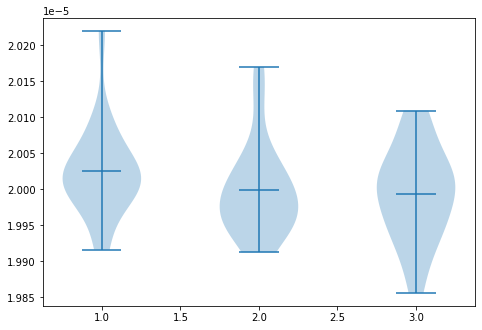

In [4]:
# Create a figure instance
fig = plt.figure()
# Create an axes instance
ax = fig.add_axes([0,0,1,1])
# Create the boxplot
bp = ax.violinplot([loss_list['Landing'], loss_list['PLAM'], loss_list['Retraction']], showmeans=True, showextrema=True)
plt.show()

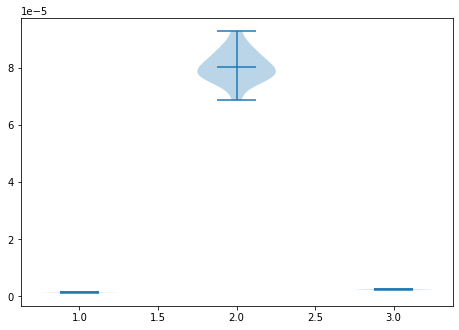

In [5]:
# Create a figure instance
fig = plt.figure()
# Create an axes instance
ax = fig.add_axes([0,0,1,1])
# Create the boxplot
bp = ax.violinplot([distance_list['Landing'], distance_list['PLAM'], distance_list['Retraction']], showmeans=True, showextrema=True)
plt.show()

In [6]:
print(np.mean(time_list['Landing']))
print(np.mean(time_list['PLAM']))
print(np.mean(time_list['Retraction']))

1.4816213607788087
1.4190149068832398
1.4094677805900573


In [7]:
print(np.mean(distance_list['Landing']))
print(np.mean(time_list['PLAM']))
print(np.mean(distance_list['Retraction']))

1.3093616018977627e-06
1.4190149068832398
2.3958967972248503e-06


In [8]:
print(np.mean(loss_list['Landing']))
print(np.mean(loss_list['PLAM']))
print(np.mean(loss_list['Retraction']))

2.0024847844979377e-05
1.999883036205574e-05
1.9993930845885188e-05
